This files is for training/generating HMMs with **two states and binary error values**.

In [20]:
from hmmlearn import hmm
import pandas as pd
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [21]:
"""
Converts the error values to binary values, based on thresholds.

return seq: binary errors of one practice opportunity
"""
def toBinary(row):
    seq = [1,1,1,1,1] # 1->good, 0-> bad
    if "left" in row["level"]:
        sides = ["left"]
    elif "right" in row["level"]:
        sides = ["right"]
    else:
        return None # change here to list with both, if wanted
    for side in sides:
        if row["pitch_" + side] >= 0.1:
            seq[0] = 0
        if row["note_hold_time_" + side] >= 3:
            seq[1] = 0
        if row["timing_" + side] >= 0.08:
            seq[2] = 0
        if row["n_missing_notes_" + side] > 0.05:
            seq[3] = 0
        if row["n_extra_notes_" + side] != 0.0:
            seq[4] = 0
    return seq

In [22]:
"""
Appends the error values of the file(sequence) to X and the length of the sequence to the array lengths. 

@param filename: name of file/sequence
@param X: array of error values for all practice opportunities of one practice mode
@param lengths: array of lengths of the individual sequences
"""
def get_sequence(filename, X, lengths):
    file = pd.read_csv(filename)
    length = 0
    for i, row in file.iterrows():
        seq = toBinary(row)
        if seq != None:
            X.append([seq[2]]) #here only choose timing error measure
            length += 1
    if length != 0:
        lengths.append(length)
    return X, lengths

In [23]:
"""
Tries to find the best HMM, by returning the model with the highest score/log probability. Note that this is
not necessarily the most reasonable, most-fitting model to the data, so exploring other models is important!

@param filename: practice mode

@return modelBest: model with the highest logProb
@return logProbMax: the highest logProb
@return PBest: the transition matrix corresponding to the best model
"""
def findBestHMM(filename):
    logProbMax = 0
    modelBest = None
    PBest = None
    for i in range(10):
        try:
            model, mus, sigmas, P, logProb, convergence = fitMultinomialHMM(X, lengths)
            if logProb > logProbMax and convergence.converged == True: #wrong do not use -> all not just highest score
                logProbMax = logProb
                modelBest = model
                PBest = P 
        except:
            continue
    with open(filename + ".pkl", "wb") as file: pickle.dump(modelBest, file)
    return modelBest, logProbMax, PBest

In [24]:
"""
Generates a Hidden Markov Model. The startprobability and initial transition probability should 
be varied between retries.

@return model:
@return mus: means of states
@return sigmas: covariance matrix
@return P: transition probability
@return logProb:score of model
@return convergence: monitors convergence of model
"""
def fitHMM(X, lengths):
    # fit Gaussian HMM to Q
    model = hmm.GaussianHMM(n_components=2, n_iter=1000, init_params="cm")
    
    model.startprob_ = np.array([1.0, 0.0]) # same initial state
    model.transmat_ = np.array([[0.8, 0.2],
                               [0.0, 1.0]])
     
    model.fit(X, lengths)
    # classify each observation as state 0 or 1
    #hidden_states = model.predict(X)
 
    # find parameters of Gaussian HMM
    convergence = model.monitor_
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(X, lengths)
 
    return model, mus, sigmas, P, logProb, convergence #hidden_states

In [25]:
"""
Generates a MULTINOMIAL Hidden Markov Model. The startprobability, initial transition probability and initial
emission probability should be varied between retries.

@return model:
@return mus: means of states
@return sigmas: covariance matrix
@return P: transition probability
@return logProb:score of model
@return convergence: monitors convergence of model
"""
def fitMultinomialHMM(X, lengths):
    # fit Gaussian HMM to Q
    model = hmm.MultinomialHMM(n_components=2, n_iter=1000, init_params="cm")
    
    model.startprob_ = np.array([1.0, 0.0]) # same initial state
    model.transmat_ = np.array([[0.8, 0.2],
                               [0.0, 1.0]])
    model.emissionprob_ = np.array([[0.9, 0.1],[0.1, 0.9]])
     
    model.fit(X, lengths)
    # classify each observation as state 0 or 1
    #hidden_states = model.predict(X)
 
    # find parameters of Gaussian HMM
    convergence = model.monitor_
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(X, lengths)
 
    return model, "no means", "no covariance", P, logProb, convergence #hidden_states

In [26]:
"""
Main: Generates models for one practice mode (directory) or iteratively for all (don't forget to save them
in that case). Change between HMM types in line 11.
"""
#for directory in ["None", "right hand", "single note", "slower", "split hands", "both hands"]:
directory = "single note"
lengths = []
X = []
for filename in os.listdir(directory):
    X, lengths = get_sequence(directory + "/" + filename, X, lengths)
model, mus, sigmas, P, logProb, convergence = fitMultinomialHMM(X, lengths) #directory equals practice mode
#model, logProb, P = findBestHMM(directory)
print("/n", directory)
print("P", P)
print("logProb", logProb)
#print("means", mus)
print("convergences", convergence)
print("")

hidden_state = model.predict(X, lengths)
index = 0
for length in lengths:
    print(hidden_state[index:index+length])
    index += length
#with open("testmodel.pkl", "wb") as file: pickle.dump(model, file)

/n single note
P [[0.81559134 0.18440866]
 [0.         1.        ]]
logProb -164.4023828556599
convergences ConvergenceMonitor(
    history=[-188.87997674439538, -166.69841923717186, -165.43172373812658, -164.98716960359766, -164.76027408102937, -164.63126240846208, -164.553011600701, -164.50304924199853, -164.4697493647632, -164.44673203540947, -164.43031867588212, -164.41829583805568, -164.40928120626256],
    iter=13,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)

[0 0 0 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0]
[0 0 0]
[0 0]
[0 1 1 1 1 1]
[0 1 1 1 1 1]
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1 1]
[0 1 1 1]
[0 1 1 1 1 1]
[0 0 0 0 0 0 0 0 1 1 

In [27]:
"""
This calculates the emission probability for the simple HMM model. Which means each input/state pair gives
its probability.
"""
import math
X = np.array(X)
model._compute_log_likelihood(X)

array([[-0.69659366, -0.13641255],
       [-0.68971254, -2.05950259],
       [-0.68971254, -2.05950259],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.68971254, -2.05950259],
       [-0.68971254, -2.05950259],
       [-0.68971254, -2.05950259],
       [-0.69659366, -0.13641255],
       [-0.68971254, -2.05950259],
       [-0.68971254, -2.05950259],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.68971254, -2.05950259],
       [-0.69659366, -0.13641255],
       [-0.69659366, -0.13641255],
       [-0.68971254, -2.05950259],
       [-0.69659366,

In [28]:
"""For saving models:"""
#with open("playRhythmBinary.pkl", "wb") as file: pickle.dump(model, file)

'For saving models:'

In [29]:
"""
Calculates and prints the state with the min/max error value(observation/performance errors) according
to the raw errors and another error metric, which adds 1 to each state if its the min/max error value in 
that error section(eg pitch).
This is then used to normalise the model. That means, that the transition matrix is saved in a way, that
column/row 0 is always the unmastered state (high error) and column/row 1 is always the mastered state 
(low error).
"""
directory = "left hand"
with open("BestThreeStates/" + directory + "/" + directory + "4.pkl", "rb") as file:
            model = pickle.load(file)
print("Transition matrix")
print(model.transmat_)

#print("Model means")
#print(model.means_)
mus = model.means_

state0 = mus[0][5] + mus[0][11]
state1 = mus[1][5] + mus[1][11]
state2 = mus[2][5] + mus[2][11]

print([state0, state1, state2])

max_error = np.argmax([state0, state1, state2])
min_error = np.argmin([state0, state1, state2])

new_max, new_min = new_error_comp(mus)

print("state with min_error:", min_error)
print("state with max error:", max_error)

print("state with new min_error:", new_min)
print("state with new max error:", new_max)
#means
#covariance
#transition
indizes = []

"""
if new_min != 2:
    if new_min == 0:
        indizes = [2,1,0]
        model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
        model.means_ = swap_row(model.means_, indizes)
    elif new_min == 1:
        print("Wow, hier läuft was schief! Das Model sollte raus")
"""
indizes = [2,1,0]
model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
model.means_ = swap_row(model.means_, indizes)

print("Transition matrix after")
print(model.transmat_)

        
with open("left hand4_new.pkl", "wb") as file: pickle.dump(model, file)


Transition matrix
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.25025781e-02 7.49995673e-01 1.87501749e-01]
 [0.00000000e+00 1.00000000e+00 7.52262820e-33]]
[1.1825672926018316, 1.0598242347352753, 1.9520265746498267]
min -1 -2 3
state with min_error: 1
state with max error: 2
state with new min_error: 1
state with new max error: 2
Transition matrix after
[[7.52262820e-33 1.00000000e+00 0.00000000e+00]
 [1.87501749e-01 7.49995673e-01 6.25025781e-02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [30]:
"""
Calculates another min/max state in regards to errors, as described above.
"""
def new_error_comp(mus):
    state0 = state1 = state2 = 0
    for i in range(len(mus[0])):
        emax = np.argmax([mus[0][i], mus[1][i], mus[2][i]])
        emin = np.argmin([mus[0][i], mus[1][i], mus[2][i]])
        if emax == 0:
            state0 += 1
        elif emax == 1:
            state1 += 1
        elif emax == 2:
            state2 += 1
        if emin == 0:
            state0 -= 1
        elif emin == 1:
            state1 -= 1
        elif emin == 2:
            state2 -= 1
    new_max = np.argmax([state0, state1, state2])
    new_min = np.argmin([state0, state1, state2])
    print("min", state0, state1, state2)
    return new_max, new_min

In [31]:
def swap_column(arr, indizes):
    arr[:, [0,1,2]] = arr[:, indizes]
    return arr

In [32]:
def swap_row(arr, indizes):
    arr[[0,1,2]] = arr[indizes]
    return arr

[1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1
 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1]


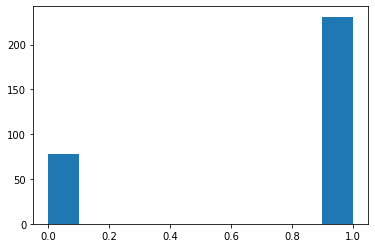

In [33]:
directory = "single note"
X = []
lengths = []
for filename in os.listdir(directory):
    X, lengths = get_sequence(directory + "/" + filename, X, lengths)
X = np.array(X)
plt.hist(X[:,0])
print(X[:,0])

In [34]:
"""
if new_min == 0 and new_max == 2:
    # 0 -> 2, 2-> 0
    indizes = [2,1,0]
elif new_min == 0 and new_max == 1:
    # 0 -> 2, 1-> 0, 2 -> 1
    indizes = [2,0,1]
elif new_min == 1 and new_max == 2:
    # 0 -> 1, 1 -> 2, 2 -> 0
    indizes = [1,2,0]
elif new_min == 1 and new_max == 0:
    # 1 -> 2, 2 -> 1
    indizes = [0,2,1]
elif new_min == 2 and new_max == 1:
    # 1 -> 0, 0 -> 1
    indizes = [1,0,2]
else:
    indizes = [0,1,2]
model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
model.means_ = swap_row(model.means_, indizes)
#model.covars_ = swap_row(model.covars_, indizes)

print(model.transmat_)
#wit

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-34-a52dac4438ba>, line 24)